In [2]:
# defining globals
root_directory = '../data'
job_info_partial_filepath = 'plugin=job_table/metric=job_info_marconi100/a_0_filter123_multinode.csv'
total_power_partial_filepath = 'plugin=ipmi_pub/metric=total_power/a_0_filter123_multinode.csv'
column_dtypes = {'resv_name': str, 'wckey': str}
start_time_col = 'start_time'
run_time_col = 'run_time'
end_time_col = 'end_time'
sum_time_col = 'sum_time'

### Checking data consistency
- Checking that start time and end time difference results in runtime for all rows in all datasets
- Checking that column names are all the same accross datasets
- Checking that dtypes are correcy for all datasets
- Checking that there are no missing values for relevant column
- Check if the timestamps of each node are all separated 20 seconds from each other

In [3]:
import os
import pandas as pd
import numpy as np

relevant_columns = ['array_job_id', 'group_id', 'job_id', 'nice',
       'num_cpus', 'num_nodes', 'partition', 'priority',
       'qos', 'run_time', 'user_id', 'node_x', 'value', 'node_y']

all_column_names = set()  # Set to use for column name consistency check
success_flag = True  # Flag to check that all consistency checks passed
chunk_size = 10000  # Chunk size for merging dataframes without using excessive memory

# Dataframe to store the merged data
merged_df_list = []
job_info_list = []

# Iterate through each month folder
for month_folder in os.listdir(root_directory):
    month_path = os.path.join(root_directory, month_folder)
    print("Month: " + month_folder)

    if os.path.isdir(month_path):
        # Creating full file paths for the job information and total power data files
        job_info_filepath = os.path.join(month_path, job_info_partial_filepath)
        total_power_filepath = os.path.join(month_path, total_power_partial_filepath)

        if os.path.exists(job_info_filepath) and os.path.exists(total_power_filepath):
            # Reading the job information and total power data files in chunks
            job_info_chunks = pd.read_csv(job_info_filepath, dtype=column_dtypes, chunksize=chunk_size)
            total_power_chunks = pd.read_csv(total_power_filepath, chunksize=chunk_size)

            # Iterating through the chunks of job information and total power data, merging them on the 'job_id' column
            for job_info_chunk, total_power_chunk in zip(job_info_chunks, total_power_chunks):
                merged_df_chunk = pd.merge(job_info_chunk, total_power_chunk, on='job_id', how='inner')

                # Append the merged chunk to the list
                merged_df_list.append(merged_df_chunk)
                job_info_list.append(job_info_chunk)

            # Concatenate all chunks into the final merged dataframe
            merged_df = pd.concat(merged_df_list, ignore_index=True)
            job_info_df = pd.concat(job_info_list, ignore_index=True)

            # Check column names consistency
            current_column_names = set(merged_df.columns)
            if not all_column_names:
                all_column_names = current_column_names
            elif current_column_names != all_column_names:
                print(f'Column names inconsistency in month {month_folder}:\n')
                print(f'Expected: {all_column_names}\n')
                print(f'Actual: {current_column_names}\n')
                print('\n---\n')
                success_flag = False

            # Check for missing values in relevant columns
            missing_values = merged_df[relevant_columns].isnull().sum()
            if not missing_values.empty and any(missing_values > 0):
                print(f'Missing values in month {month_folder}:\n')
                print(missing_values[missing_values > 0])
                print('\n---\n')
                success_flag = False

            # Check if timestamps for each node are separated by 20 seconds
            for job in merged_df['job_id'].unique():
                node_data = merged_df[merged_df['job_id'] == job].sort_values(by='timestamp')
                time_diff = pd.to_datetime(node_data['timestamp']).diff().iloc[1:].dt.total_seconds()
                
                if not (time_diff == 20.0).all():
                    print(time_diff[time_diff != 20.0])
                    print(f'Timestamps for job {job} in month {month_folder} are not separated by 20 seconds.\n')
                    success_flag = False

if success_flag:
    print("All checks passed successfully for all files.")

Month: year_month=22-05
664     0.0
665     0.0
666     0.0
667     0.0
668     0.0
       ... 
485     0.0
1150    0.0
487     0.0
488     0.0
489     0.0
Name: timestamp, Length: 490, dtype: float64
Timestamps for job 1194689 in month year_month=22-05 are not separated by 20 seconds.

3250    0.0
1851    0.0
3252    0.0
3253    0.0
3254    0.0
       ... 
3245    0.0
3246    0.0
3247    0.0
3248    0.0
4649    0.0
Name: timestamp, Length: 1400, dtype: float64
Timestamps for job 1519079 in month year_month=22-05 are not separated by 20 seconds.

8109    0.0
6709    0.0
8111    0.0
8112    0.0
8113    0.0
       ... 
8104    0.0
8105    0.0
8106    0.0
8107    0.0
9509    0.0
Name: timestamp, Length: 1401, dtype: float64
Timestamps for job 533906 in month year_month=22-05 are not separated by 20 seconds.

Month: year_month=22-03
664     0.0
665     0.0
666     0.0
667     0.0
668     0.0
       ... 
485     0.0
1150    0.0
487     0.0
488     0.0
489     0.0
Name: timestamp, Length: 49

In [4]:
print("Total users in the cluster", merged_df['user_id'].nunique())
print("Total jobs in the cluster", job_info_df['job_id'].nunique())
print("First measurement date: ", merged_df['timestamp'].min())
print("Last measurement date: ", merged_df['timestamp'].max())

Total users in the cluster 64
Total jobs in the cluster 120550
First measurement date:  2022-01-04 23:00:00+00:00
Last measurement date:  2022-09-11 21:59:40+00:00


### Plotting run time, power consumption and number of CPUs distributions

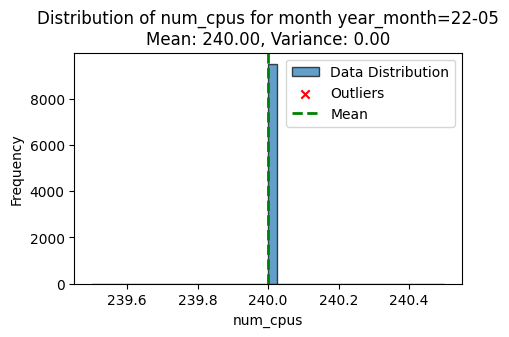

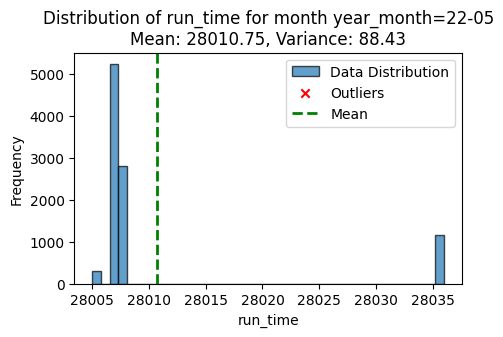

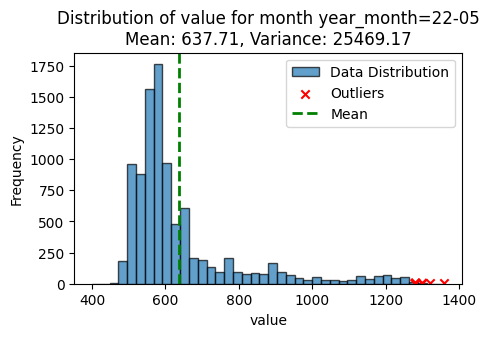

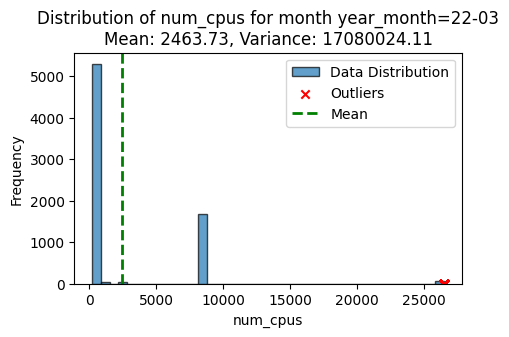

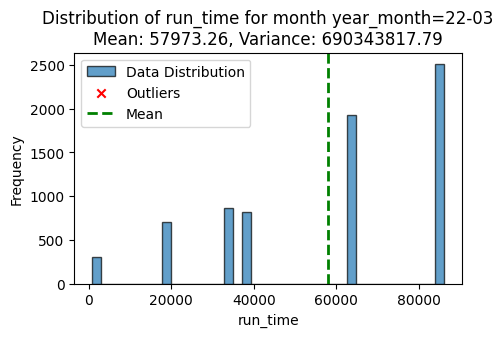

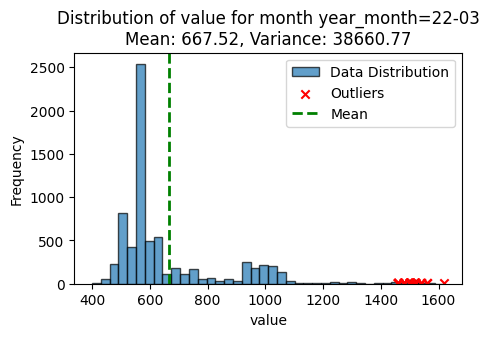

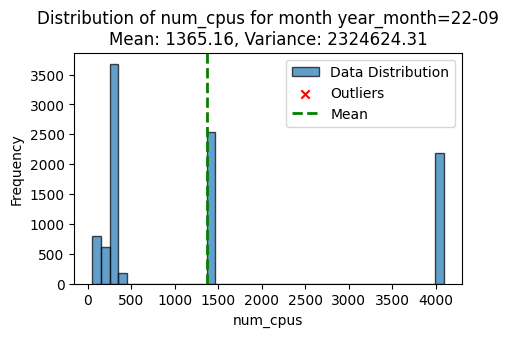

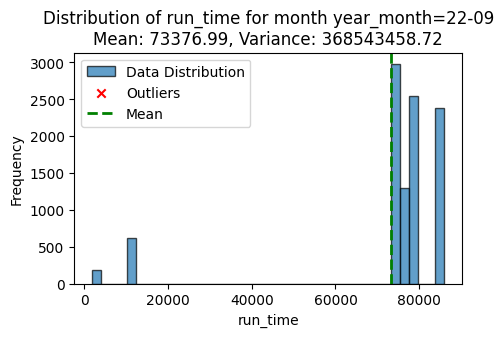

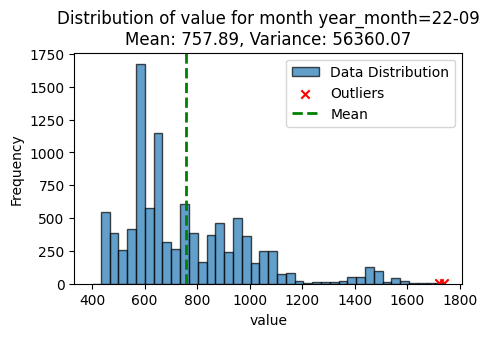

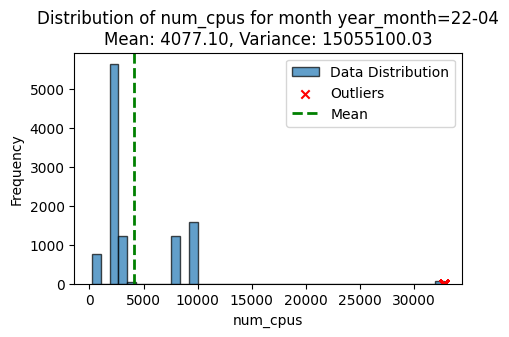

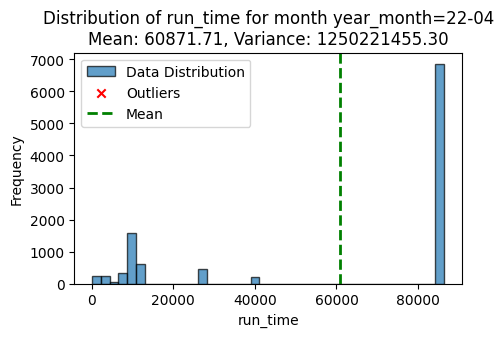

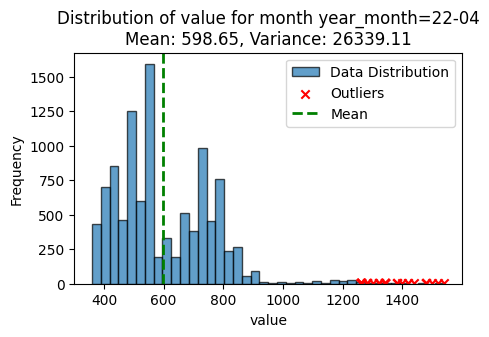

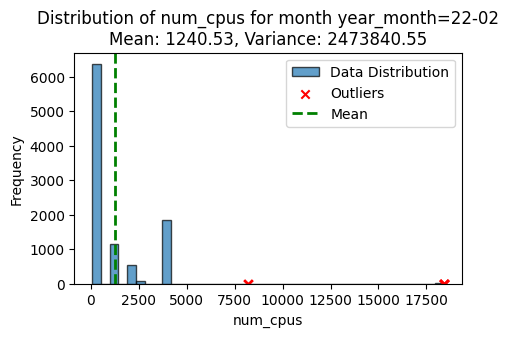

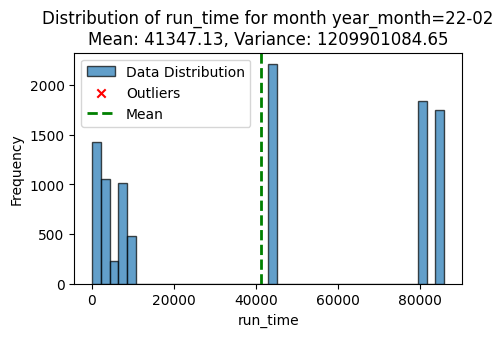

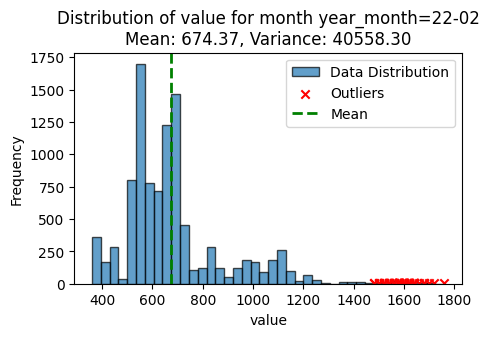

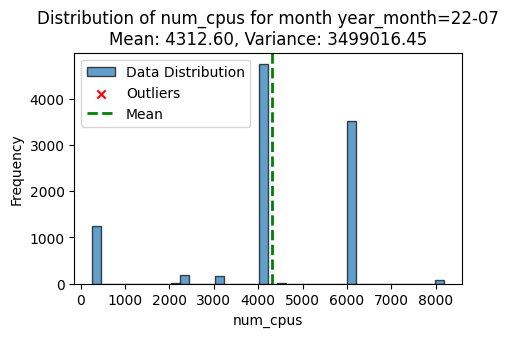

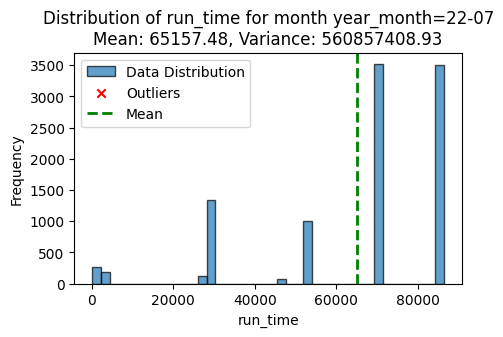

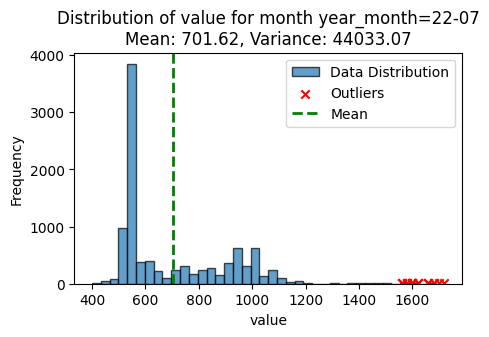

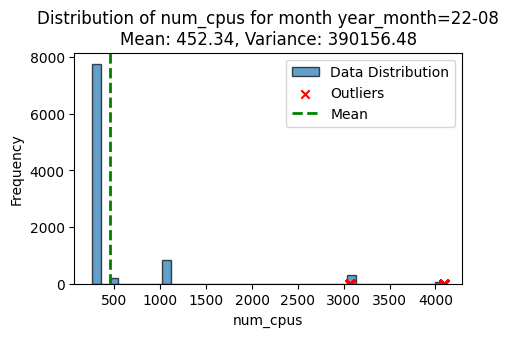

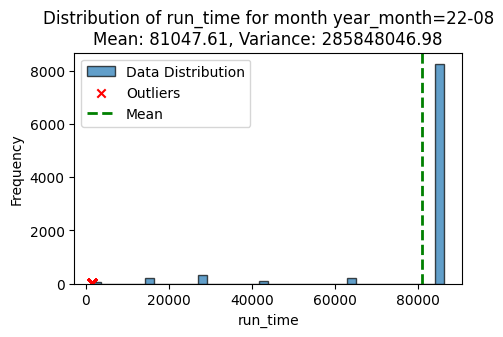

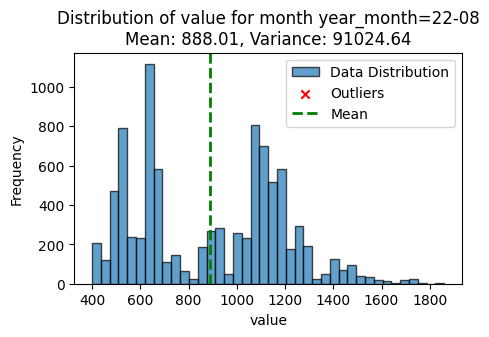

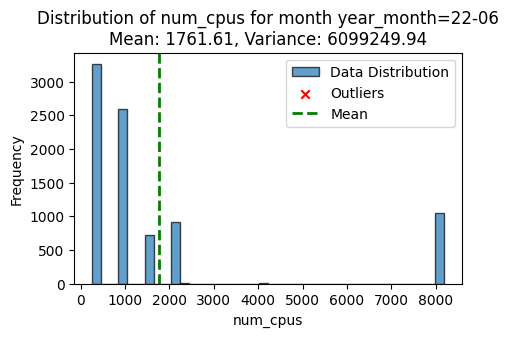

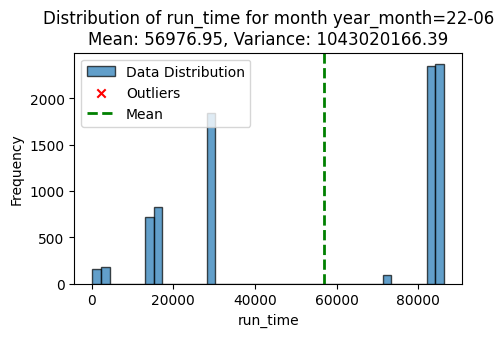

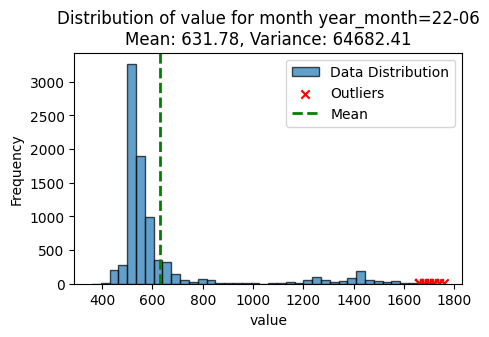

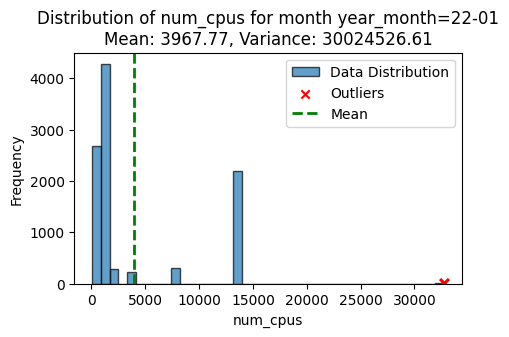

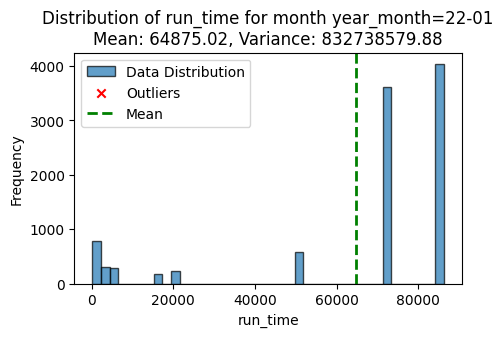

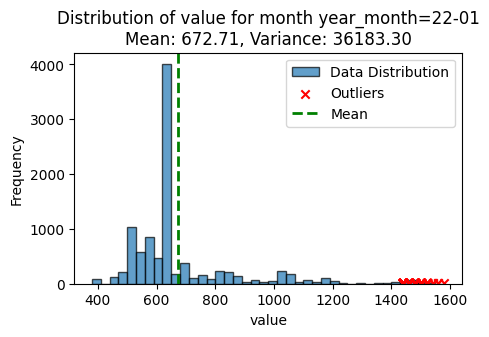

In [5]:
import matplotlib.pyplot as plt

z_score_threshold = 4.0 # z-score threshold for outlier detection
cols = ['num_cpus', 'run_time', 'value'] # Columns used for plots

# Iterate through each month folder
for month_folder in os.listdir(root_directory):
    month_path = os.path.join(root_directory, month_folder)

    if os.path.isdir(month_path):
        # Creating full file paths for the job information and total power data files
        job_info_filepath = os.path.join(month_path, job_info_partial_filepath)
        total_power_filepath = os.path.join(month_path, total_power_partial_filepath)

        if os.path.exists(job_info_filepath) and os.path.exists(total_power_filepath):
            job_info_chunks = pd.read_csv(job_info_filepath, dtype=column_dtypes, chunksize=chunk_size)
            total_power_chunks = pd.read_csv(total_power_filepath, chunksize=chunk_size)
            merged_df = pd.DataFrame()

            for job_info_chunk, total_power_chunk in zip(job_info_chunks, total_power_chunks):
                merged_df_chunk = pd.merge(job_info_chunk, total_power_chunk, on='job_id', how='inner')
                merged_df = pd.concat([merged_df, merged_df_chunk], ignore_index=True)

            for col in cols:
                z_scores = np.abs((merged_df[col] - merged_df[col].mean()) / merged_df[col].std())
                outliers = merged_df[z_scores > z_score_threshold]
                
                # Plot distribution with mean, variance, and outliers
                plt.figure(figsize=(5, 3))
                plt.title(f'Distribution of {col} for month {month_folder}\nMean: {merged_df[col].mean():.2f}, Variance: {merged_df[col].var():.2f}')
                plt.hist(merged_df[col], bins=40, edgecolor='black', alpha=0.7, label='Data Distribution')
                plt.scatter(outliers[col], np.full_like(outliers[col], 5), color='red', marker='x', label='Outliers')
                plt.axvline(merged_df[col].mean(), color='green', linestyle='dashed', linewidth=2, label='Mean')
                plt.xlabel(col)
                plt.ylabel('Frequency')
                plt.legend()
                plt.show()

### Visualizing the time series of power consumption for the longest running job in Marconi during 22-08

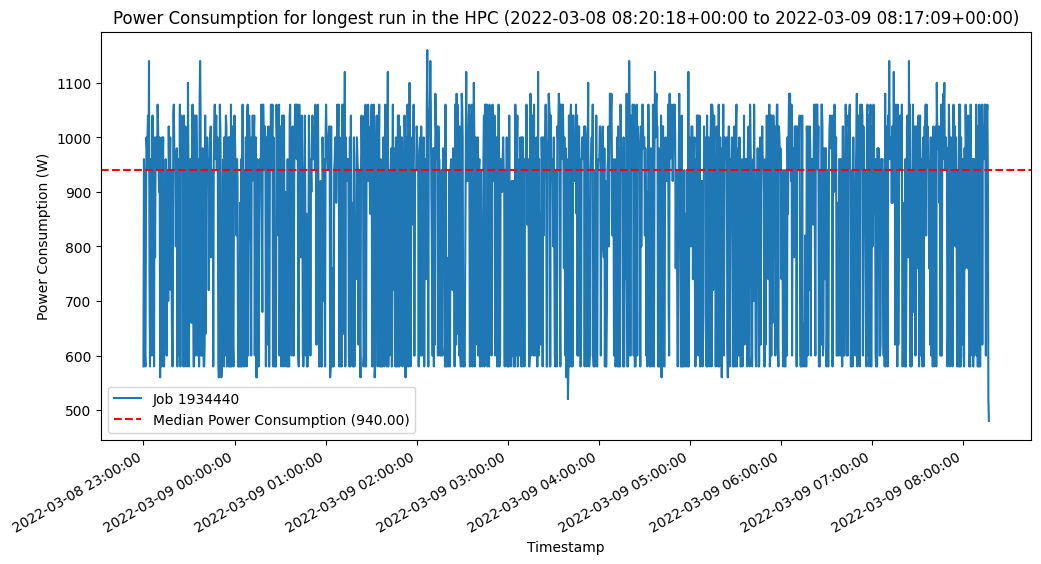

In [6]:
import matplotlib.dates as mdates

timestamp_col = 'timestamp'
runtime_col = 'run_time'
power_col = 'value'

month_path = os.path.join(root_directory, "year_month=22-03") # month = August 2022

# Build merged df for the month of August 2022
if os.path.isdir(month_path):
    job_info_filepath = os.path.join(month_path, job_info_partial_filepath)
    total_power_filepath = os.path.join(month_path, total_power_partial_filepath)

    if os.path.exists(job_info_filepath) and os.path.exists(total_power_filepath):
        job_info_chunks = pd.read_csv(job_info_filepath, dtype=column_dtypes, chunksize=chunk_size)
        total_power_chunks = pd.read_csv(total_power_filepath, chunksize=chunk_size)
        merged_df = pd.DataFrame()

        for job_info_chunk, total_power_chunk in zip(job_info_chunks, total_power_chunks):
            merged_df_chunk = pd.merge(job_info_chunk, total_power_chunk, on='job_id', how='inner')
            merged_df = pd.concat([merged_df, merged_df_chunk], ignore_index=True)

# Find the row corresponding to the longest running job
longest_running_job_row = merged_df.loc[merged_df[runtime_col].idxmax()]
start_time = longest_running_job_row['start_time']
end_time = longest_running_job_row['end_time']

# DataFrame containing the timestamp and power consumption values for the job with the longest run time
longest_running_job_power = merged_df[merged_df['job_id'] == longest_running_job_row['job_id']][[timestamp_col, power_col]]

# Calculate the median of power consumption
median_power_consumption = longest_running_job_power[power_col].median()

# Convert timestamp values to datetime objects
longest_running_job_power[timestamp_col] = pd.to_datetime(longest_running_job_power[timestamp_col])

# Plot the time series of power consumption for the longest running job
plt.figure(figsize=(12, 6))
plt.plot(longest_running_job_power[timestamp_col], longest_running_job_power[power_col], label=f'Job {longest_running_job_row["job_id"]}')
plt.axhline(y=median_power_consumption, color='r', linestyle='--', label=f'Median Power Consumption ({median_power_consumption:.2f})')
plt.title(f'Power Consumption for longest run in the HPC ({start_time} to {end_time})')
plt.xlabel('Timestamp')
plt.ylabel('Power Consumption (W)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability
plt.legend()
plt.show()

### Applying Fourier Transform to the time series of power consumption for the longest running job

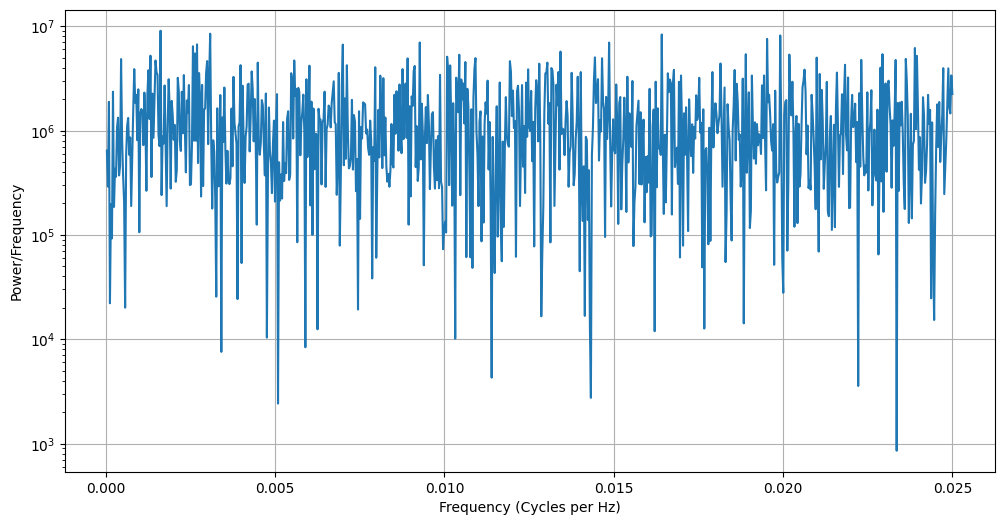

In [7]:
from scipy.signal import periodogram

# ensure timestamps are sorted
longest_running_job_power = longest_running_job_power.sort_values(timestamp_col)

# power consumption values
power_values = longest_running_job_power[power_col].values

# Fourier transform to get periodogram using 1/20 as sampling freq since all timestamps are 20 secs from each other
frequencies, power_spectrum = periodogram(power_values, fs=1/20)

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies[1:], power_spectrum[1:])
plt.xlabel('Frequency (Cycles per Hz)')
plt.ylabel('Power/Frequency')
plt.grid(True)
plt.show()

For example, if there's a strong periodic pattern in the time series that repeats every 24 hours, we might see a peak in the periodogram at a frequency corresponding to 1 cycle per 24 hours (the inverse of the period).

### Setting a threshold and finding periodicity hints

In [8]:
from scipy.signal import find_peaks

max_spectral_powers = []

# Generate permuted sequences, calculate periodogram, record max spectral powers
for _ in range(100):
    permuted_sequence = np.random.permutation(power_values)
    _, spectrum = periodogram(permuted_sequence, fs=1/20)
    max_spectral_powers.append(np.max(spectrum))

threshold = np.sort(max_spectral_powers)[-99]
peaks, _ = find_peaks(power_spectrum, height=threshold)

# extract frequencies corresponding to peaks
period_hints_in_minutes = (1 / frequencies[peaks]) / 60
print("Periods in Minutes:", period_hints_in_minutes)

Periods in Minutes: [10.32098765  5.41100324  1.01517911  0.85349668  0.83683684]


With the periodicity hint found (~3 minutes), we can zoom in the plot to show the power consumption patter of the job during 20 minutes, because that patter is likely repeating itself over the course of the job's whole execution time.

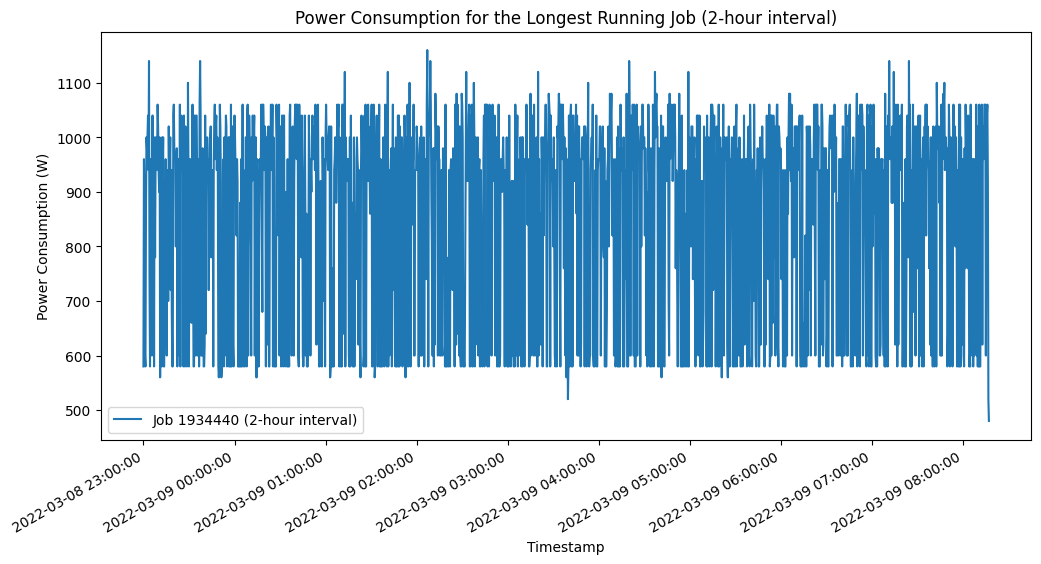

In [9]:
# Plot the power consumption over a 20-minute interval
interval_data = longest_running_job_power[
    (longest_running_job_power[timestamp_col] >= start_time) &
    (longest_running_job_power[timestamp_col] <= pd.to_datetime(start_time) + pd.Timedelta(hours=24))
]

plt.figure(figsize=(12, 6))
plt.plot(interval_data[timestamp_col], interval_data[power_col], label=f'Job {longest_running_job_row["job_id"]} (2-hour interval)')
plt.title(f'Power Consumption for the Longest Running Job (2-hour interval)')
plt.xlabel('Timestamp')
plt.ylabel('Power Consumption (W)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability
plt.legend()
plt.show()

### Visualizing the time series of total power consumption in Marconi during the month of August

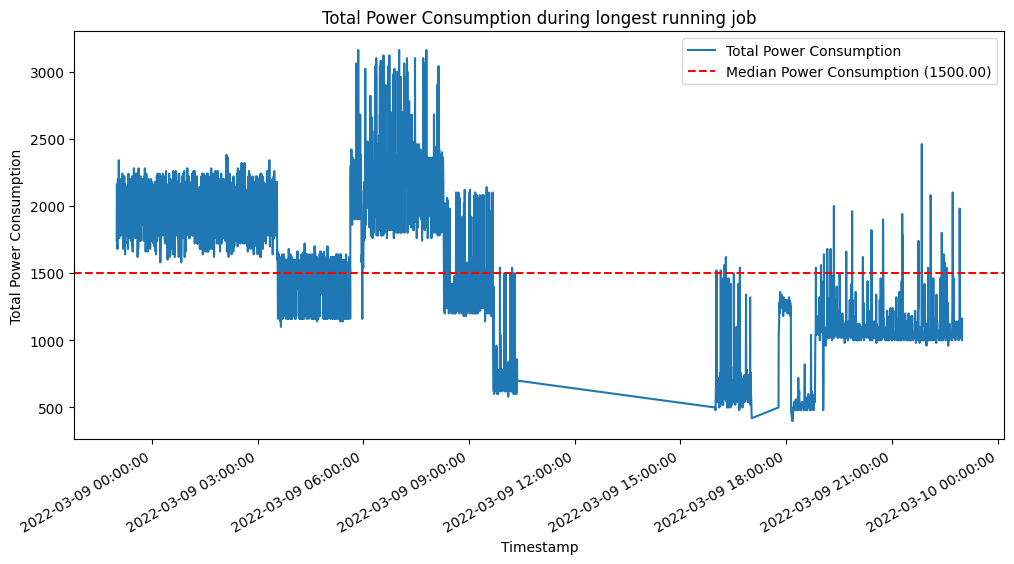

In [10]:
power_data = merged_df[[timestamp_col, power_col]]

# Group by timestamp and sum the power consumption values
total_power_by_timestamp = power_data.groupby(timestamp_col)[power_col].sum().reset_index()

median_total_power = total_power_by_timestamp[power_col].median()

total_power_by_timestamp[timestamp_col] = pd.to_datetime(total_power_by_timestamp[timestamp_col])

plt.figure(figsize=(12, 6))
plt.plot(total_power_by_timestamp[timestamp_col], total_power_by_timestamp[power_col], label='Total Power Consumption')
plt.axhline(y=median_total_power, color='r', linestyle='--', label=f'Median Power Consumption ({median_total_power:.2f})')
plt.title('Total Power Consumption during longest running job')
plt.xlabel('Timestamp')
plt.ylabel('Total Power Consumption')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

### See the work of a single node during the month/week/day

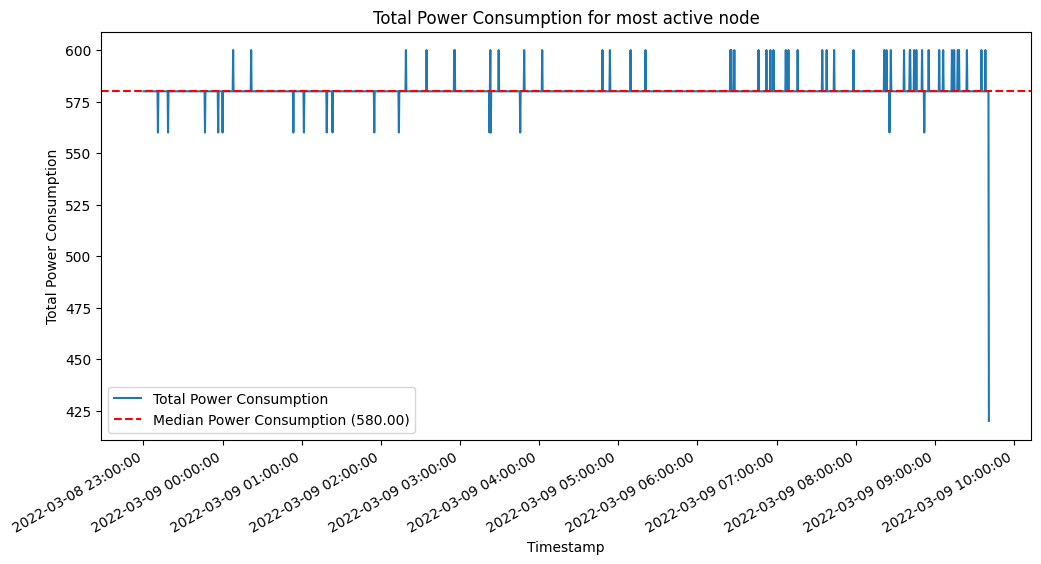

In [11]:
most_active_nodes_rows = merged_df[merged_df['nodes'] == merged_df['nodes'].value_counts().idxmax()] # get the node with the most activity
power_data = most_active_nodes_rows[[timestamp_col, power_col]]
total_power_by_timestamp = power_data.groupby(timestamp_col)[power_col].sum().reset_index()
median_total_power = total_power_by_timestamp[power_col].median()
total_power_by_timestamp[timestamp_col] = pd.to_datetime(total_power_by_timestamp[timestamp_col])

plt.figure(figsize=(12, 6))
plt.plot(total_power_by_timestamp[timestamp_col], total_power_by_timestamp[power_col], label='Total Power Consumption')
plt.axhline(y=median_total_power, color='r', linestyle='--', label=f'Median Power Consumption ({median_total_power:.2f})')
plt.title('Total Power Consumption for most active node')
plt.xlabel('Timestamp')
plt.ylabel('Total Power Consumption')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

### For each user, calculate energy consumption of all their jobs (integral of power/time curve) and sum them, and do it for all users, then calculate histogram with energy consumption for each user

64


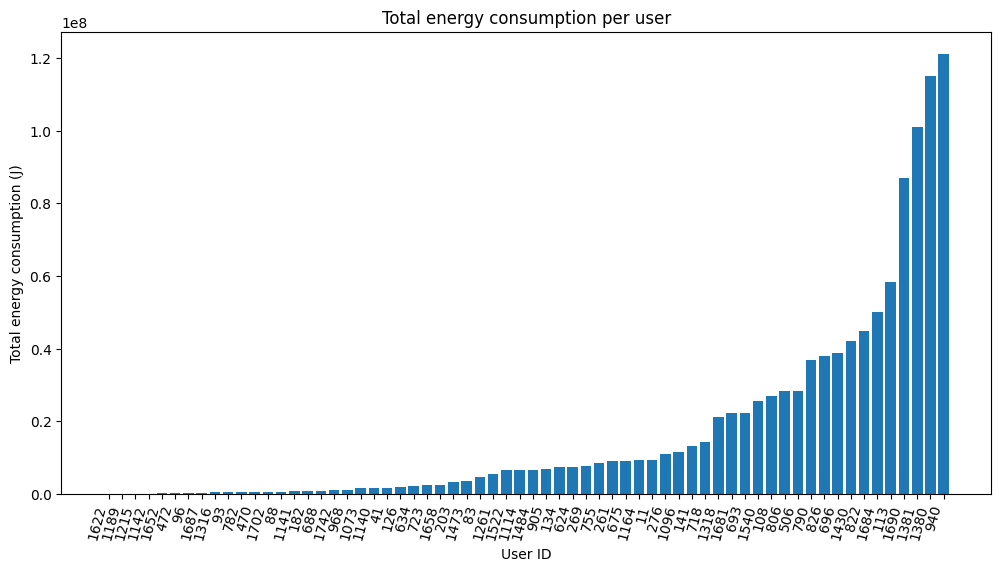

In [12]:
energy_consumption_per_users = pd.DataFrame(columns=['user_id', 'energy_consumed'])

# Data frame to store energy consumption values per user ID and job ID
energy_consumption_per_jobs = pd.DataFrame(columns=['user_id', 'job_id', 'energy_consumed_by_job', 'num_cpus', 'num_nodes', 'run_time', 'job_state'])

# Iterate through months
for month_folder in os.listdir(root_directory):
    month_path = os.path.join(root_directory, month_folder)
    if os.path.isdir(month_path):
        job_info_filepath = os.path.join(month_path, job_info_partial_filepath)
        total_power_filepath = os.path.join(month_path, total_power_partial_filepath)
        if os.path.exists(job_info_filepath) and os.path.exists(total_power_filepath):
            
            # Create merged df
            job_info_chunks = pd.read_csv(job_info_filepath, dtype=column_dtypes, chunksize=chunk_size)
            total_power_chunks = pd.read_csv(total_power_filepath, chunksize=chunk_size)
            merged_df = pd.DataFrame()            
            for job_info_chunk, total_power_chunk in zip(job_info_chunks, total_power_chunks):
                merged_df_chunk = pd.merge(job_info_chunk, total_power_chunk, on='job_id', how='inner')
                merged_df = pd.concat([merged_df, merged_df_chunk], ignore_index=True)
            merged_df[timestamp_col] = pd.to_datetime(merged_df[timestamp_col])
            
            # Calculate energy consumption for each user by summing up the energy consumed by each of their jobs
            for user_id in merged_df['user_id'].unique():
                total_energy_consumed_by_user = 0
                user_data = merged_df[merged_df['user_id'] == user_id]

                for job_id in user_data['job_id'].unique():
                    job_data = merged_df[merged_df['job_id'] == job_id]

                    # Total energy consumed by the job is the integral of the power consumption time series curve
                    total_energy_consumed_by_this_job = np.trapz(job_data[power_col], x=job_data[timestamp_col].astype(int) // 10**9)
                    
                    # Add this and other relevant info to the job entry on the df
                    energy_consumption_per_jobs = pd.concat([energy_consumption_per_jobs, pd.DataFrame({
                                            'user_id': [user_id], 
                                            'job_id': [job_id], 
                                            'total_energy_consumed_by_job': [total_energy_consumed_by_this_job],
                                            'num_cpus': [job_data['num_cpus'].iloc[0]],
                                            'num_nodes': [job_data['num_nodes'].iloc[0]],
                                            'run_time': [job_data['run_time'].iloc[0]],
                                            'job_state': [job_data['job_state'].iloc[0]],
                                        })])
                    
                    # Add total energy of this job to total energy cumulative of the user
                    total_energy_consumed_by_user += total_energy_consumed_by_this_job
                
                # Add this user's energy consumption info to the data frame
                energy_consumption_per_users = pd.concat([energy_consumption_per_users, pd.DataFrame({'user_id': [str(user_id)], 'energy_consumed': [total_energy_consumed_by_user]})])

# Group by user_id, sum total energy consumption values then sort rows by energy consumption values in ascending order
energy_consumption_per_users = energy_consumption_per_users.groupby('user_id')['energy_consumed'].sum().reset_index().sort_values(by='energy_consumed')
print(len(energy_consumption_per_users))

plt.figure(figsize=(12,6))
plt.bar(energy_consumption_per_users['user_id'].astype(str), energy_consumption_per_users['energy_consumed'])
plt.title('Total energy consumption per user')
plt.xlabel('User ID')
plt.ylabel('Total energy consumption (J)')
plt.xticks(rotation=75, ha='right')
plt.show()


### Calculate the CDF of power consumption per user

9.99% of the users are responsible for 50% of total energy consumption.


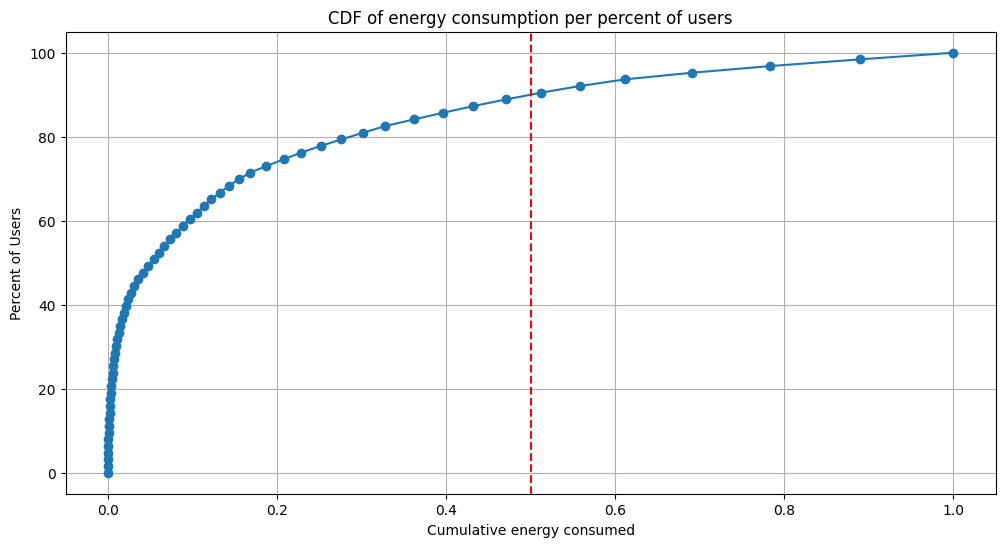

In [13]:
from scipy.interpolate import interp1d

cumulative_percentage = np.linspace(0, 100, len(energy_consumption_per_users))
cumulative_energy = np.cumsum(energy_consumption_per_users['energy_consumed']) / np.sum(energy_consumption_per_users['energy_consumed'])

interp_function = interp1d(cumulative_energy, cumulative_percentage, kind='linear')
percent_half_consumption = 100 - interp_function(0.5)
print(f"{percent_half_consumption:.2f}% of the users are responsible for 50% of total energy consumption.")

plt.figure(figsize=(12,6))
plt.plot(cumulative_energy, cumulative_percentage, marker='o')
plt.axvline(x=0.5, color='red', linestyle='--')
plt.title('CDF of energy consumption per percent of users')
plt.xlabel('Cumulative energy consumed')
plt.ylabel('Percent of Users')
plt.grid(True)
plt.show()

The graph shows that for about the first 80% of users, the CDF increases slowly, indicating that these users consume a relatively low amount of power.

After around 80%, there’s a steep increase in the CDF, showing that this small percentage of users consumes a significant amount of power.

In [14]:
print(energy_consumption_per_users.describe(percentiles=[0.8,0.6,0.95]))

       energy_consumed
count     6.400000e+01
mean      1.706051e+07
std       2.732209e+07
min       2.440000e+04
50%       6.565000e+06
60%       8.817680e+06
80%       2.747676e+07
95%       8.271894e+07
max       1.212032e+08


The large difference between the mean and the median suggests that the power consumption values are skewed, with a few very large values pulling the mean up. 

This also shows us how the power consumption data is spread out, since the jump from the 80th percentile to the 95th percentile suggests that the top 20% of user IDs consumed significantly larger amounts of power.

### Correlations between job geometry (number of nodes and CPUs) with total energy consumed by the job

In [15]:
import scipy.stats

# Convert 'num_cpus' and 'num_nodes' to numeric
energy_consumption_per_jobs['num_cpus'] = pd.to_numeric(energy_consumption_per_jobs['num_cpus'])
energy_consumption_per_jobs['num_nodes'] = pd.to_numeric(energy_consumption_per_jobs['num_nodes'])

# Calculate correlations and p-values between total energy consumed by job and its caracteristics
columns = ['total_energy_consumed_by_job', 'num_cpus', 'num_nodes', 'run_time']
corr_matrix = energy_consumption_per_jobs[columns].corr()
pval_matrix = energy_consumption_per_jobs[columns].apply(lambda x: energy_consumption_per_jobs[columns].apply(lambda y: scipy.stats.pearsonr(x,y)[1]))

# Create a dataframe for the correlation and p-values
corr_pval_df = pd.DataFrame([(i, j, corr_matrix.loc[i, j], pval_matrix.loc[i, j]) for i in columns for j in columns if i != j], columns = ['Variable 1', 'Variable 2', 'Correlation', 'P-Value'])

print(corr_pval_df[corr_pval_df['Variable 1'] == 'total_energy_consumed_by_job'])

                     Variable 1 Variable 2  Correlation       P-Value
0  total_energy_consumed_by_job   num_cpus    -0.062171  4.276055e-01
1  total_energy_consumed_by_job  num_nodes    -0.055492  4.789826e-01
2  total_energy_consumed_by_job   run_time     0.702413  7.537343e-26


### Percentage of high consuming jobs per job state
Considering the jobs of the 4 top consuming user IDS. 

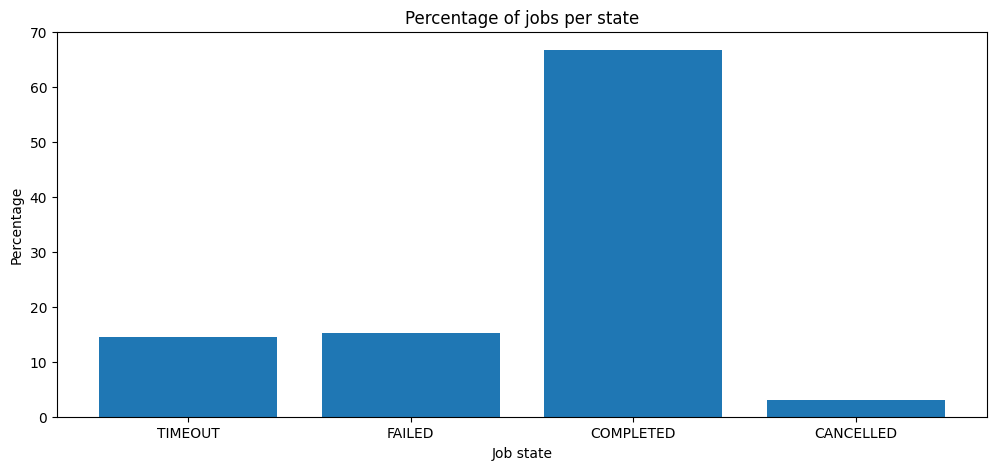

In [16]:
# consumers = energy_consumption_per_users['user_id'].to_list()
# top_consumers_jobs = energy_consumption_per_jobs[energy_consumption_per_jobs['user_id'].isin(consumers)]

job_states = ['TIMEOUT', 'FAILED', 'COMPLETED', 'CANCELLED']
percentages = energy_consumption_per_jobs['job_state'].value_counts(normalize=True).loc[job_states] * 100

plt.figure(figsize=(12,5))
plt.bar(job_states, percentages)
plt.xlabel('Job state')
plt.ylabel('Percentage')
plt.title('Percentage of jobs per state')
plt.show()

### Total energy consumed per job state
Considering the whole dataset.

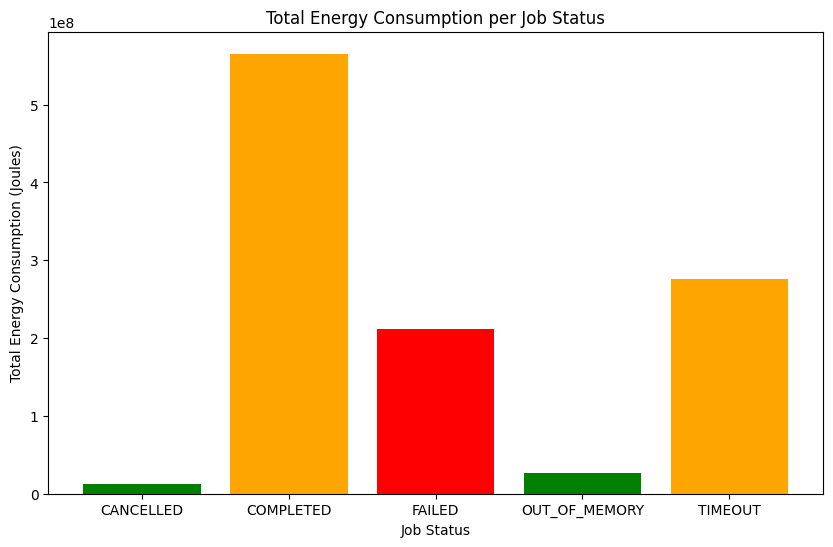

In [17]:
energy_consumption_per_status = energy_consumption_per_jobs.groupby('job_state')['total_energy_consumed_by_job'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.bar(energy_consumption_per_status['job_state'], energy_consumption_per_status['total_energy_consumed_by_job'], color=['green', 'orange', 'red'])
plt.title('Total Energy Consumption per Job Status')
plt.xlabel('Job Status')
plt.ylabel('Total Energy Consumption (Joules)')
plt.show()


### Function to convert time limit strings into total seconds

In [18]:
def convert_time_limit(time_limit_str):
    # Split the string into components
    components = time_limit_str.split('-')

    # Convert each component to timedelta
    days = int(components[0]) if len(components) > 1 else 0
    time_components = components[-1].split(':')
    hours = int(time_components[0])
    minutes = int(time_components[1]) if len(time_components) > 1 else 0
    seconds = int(time_components[2]) if len(time_components) > 2 else 0

    # Calculate total seconds
    total_seconds = days * 24 * 60 * 60 + hours * 60 * 60 + minutes * 60 + seconds
    return total_seconds

### Trying to predict job state based on job info prior to execution
Job info being considered: user ID, number of nodes, number of CPUs, start hour, tres per node and time limit chosen by the user.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE

relevant_job_states = ['TIMEOUT', 'FAILED', 'COMPLETED']

# Read job info pre execution to a dataframe for all months
job_info_pre_execution = pd.DataFrame()
selected_columns = ['user_id', 'num_nodes', 'num_cpus', 'time_limit_str', 'job_state', 'start_time', 'tres_per_node']
for month_folder in os.listdir(root_directory):
    month_path = os.path.join(root_directory, month_folder)
    job_info_filepath = os.path.join(month_path, job_info_partial_filepath)
    if os.path.exists(job_info_filepath):
        current_month_df = pd.read_csv(job_info_filepath, dtype=column_dtypes)
        current_month_df = current_month_df[selected_columns]
        job_info_pre_execution = pd.concat([job_info_pre_execution, current_month_df], ignore_index=True)

# Clean and format columns
job_info_pre_execution['tres_per_node'] = job_info_pre_execution['tres_per_node'].str.extract(r'(\d+)').astype(float)
job_info_pre_execution['time_limit'] = job_info_pre_execution['time_limit_str'].apply(convert_time_limit)
job_info_pre_execution['start_hour'] = pd.to_datetime(job_info_pre_execution['start_time']).dt.hour
job_info_pre_execution.dropna(subset=selected_columns, inplace=True)

# Filter dataset to include only relevant job states
job_info_pre_execution = job_info_pre_execution[job_info_pre_execution['job_state'].isin(relevant_job_states)]

# Select and extract features and target variable
features = ['user_id', 'num_nodes', 'num_cpus', 'time_limit', 'start_hour', 'tres_per_node']
target = 'job_state'

# Use one-hot encoding for 'user_id' column
X_encoded = pd.get_dummies(job_info_pre_execution[features + [target]], columns=['user_id'], prefix='user')

# Split in train and test sets
X = X_encoded.drop(columns=[target])
y = X_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Do under sampling on the majority class COMPLETED
timeouted_jobs = y_train.value_counts()['TIMEOUT']
failed_count = y_train.value_counts()['FAILED']
completed_count = y_train.value_counts()['COMPLETED']
sampling_strategy_dict = {'COMPLETED': int(completed_count/10), 'FAILED': failed_count, 'TIMEOUT': timeouted_jobs}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy_dict, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Build logistic regression model using RFE
model = LogisticRegression(max_iter=10000, random_state=42)

rfe = RFE(estimator=model)
rfe.fit(X_resampled, y_resampled)
selected_features = X_resampled.columns[rfe.support_]
X_resampled_selected = rfe.transform(X_resampled)
X_test_selected = rfe.transform(X_test)

# Fit logistic regression model on the selected features
model.fit(X_resampled_selected, y_resampled)

# Evaluate the model
predictions = model.predict(X_test_selected)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

Accuracy: 0.62
              precision    recall  f1-score   support

   COMPLETED       0.96      0.58      0.72     16945
      FAILED       0.31      0.88      0.46      3100
     TIMEOUT       0.36      0.55      0.43      1843

    accuracy                           0.62     21888
   macro avg       0.54      0.67      0.54     21888
weighted avg       0.82      0.62      0.66     21888

[[9833 5395 1717]
 [ 228 2740  132]
 [ 150  675 1018]]


In [86]:

# Create a dataframe with the selected features
selected_features_df = pd.DataFrame(X_test_selected, columns=selected_features)

# One-hot encode the predicted class labels
predicted_classes_one_hot = pd.get_dummies(predictions, prefix='Predicted_Class', columns=model.classes_)

# Concatenate the one-hot encoded columns with the selected features dataframe
selected_features_df = pd.concat([selected_features_df, predicted_classes_one_hot], axis=1)

# Display the updated dataframe
print(selected_features_df.corr())


                             user_5    user_7    user_8   user_11   user_17  \
user_5                     1.000000 -0.000382 -0.000323 -0.001139 -0.000992   
user_7                    -0.000382  1.000000 -0.000270 -0.000953 -0.000830   
user_8                    -0.000323 -0.000270  1.000000 -0.000806 -0.000701   
user_11                   -0.001139 -0.000953 -0.000806  1.000000 -0.002472   
user_17                   -0.000992 -0.000830 -0.000701 -0.002472  1.000000   
...                             ...       ...       ...       ...       ...   
user_1742                 -0.000479 -0.000401 -0.000339 -0.001195 -0.001040   
user_1743                 -0.000501 -0.000419 -0.000354 -0.001248 -0.001086   
Predicted_Class_COMPLETED -0.019992 -0.016726 -0.014135 -0.049840 -0.043379   
Predicted_Class_FAILED    -0.017547 -0.014680 -0.012406  0.064937  0.056519   
Predicted_Class_TIMEOUT    0.055068  0.046070  0.038934 -0.020692 -0.018010   

                            user_35   user_41   use

In [89]:
for feature in features_to_check:
    print(selected_features_df[feature].unique())
    print(selected_features_df[feature].value_counts())

print(selected_features_df)

[0.]
0.0    21888
Name: user_205, dtype: int64
[0.]
0.0    21888
Name: user_567, dtype: int64
[0.]
0.0    21888
Name: user_884, dtype: int64
[0.]
0.0    21888
Name: user_1053, dtype: int64
[0.]
0.0    21888
Name: user_1099, dtype: int64
[0.]
0.0    21888
Name: user_1232, dtype: int64
[0.]
0.0    21888
Name: user_1349, dtype: int64
[0.]
0.0    21888
Name: user_1438, dtype: int64
       user_5  user_7  user_8  user_11  user_17  user_35  user_41  user_44  \
0         0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0   
1         0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0   
2         0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0   
3         0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0   
4         0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.0   
...       ...     ...     ...      ...      ...      ...      ...      ...   
21883     0.0     0.0     0.0      0.0      0.0      0.0      0.0      0.

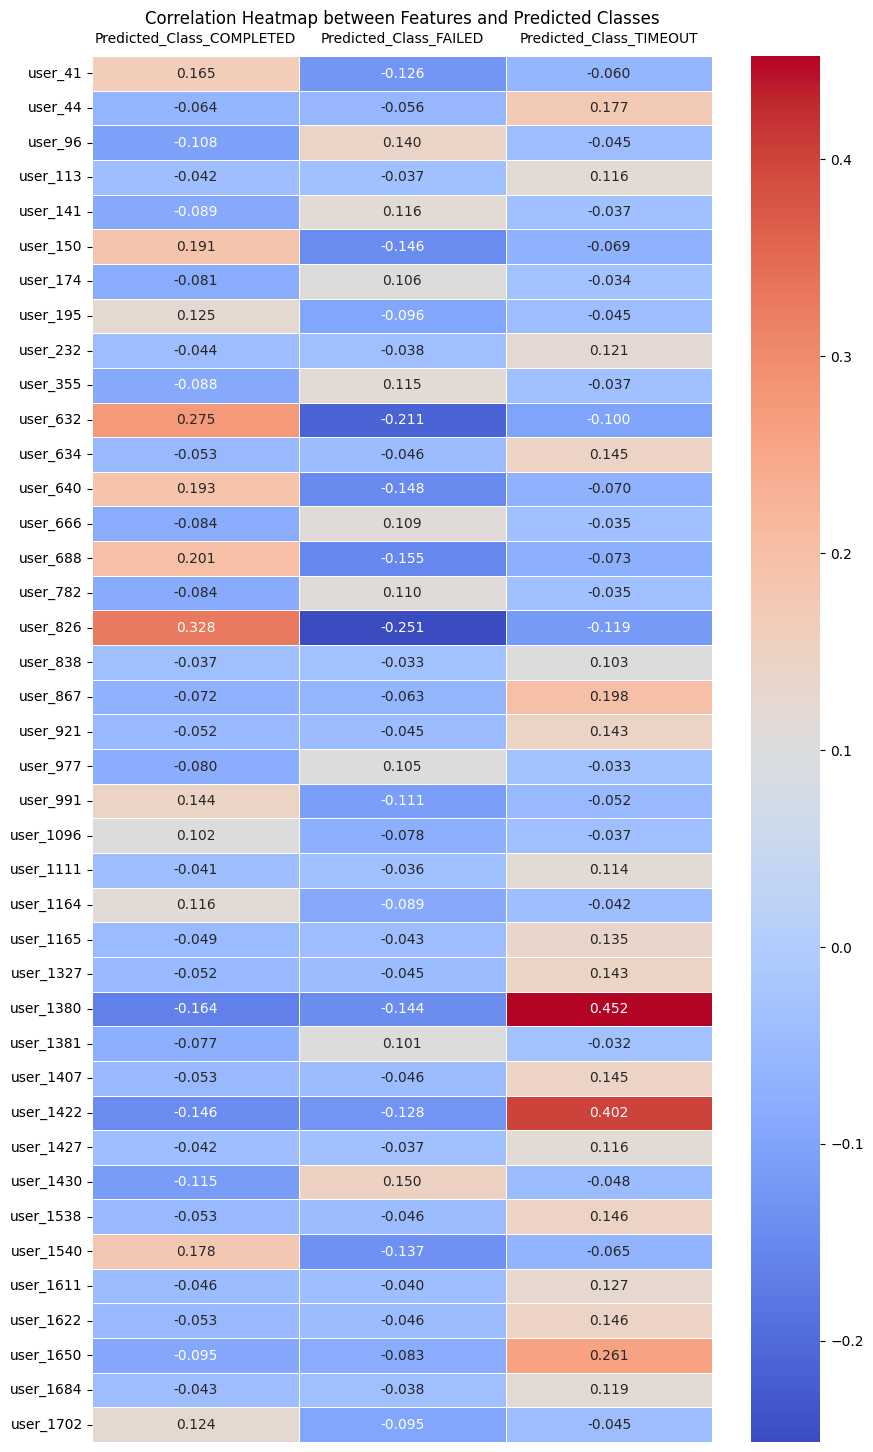

In [106]:
import seaborn as sns

# Remove features with all zero values
non_zero_features = selected_features_df.loc[:, (selected_features_df != 0).any(axis=0)]

# Get correlation values between features and expected values for traget variable job_state
correlation_matrix = non_zero_features.corr().iloc[:-3, -3:]
correlation_matrix = correlation_matrix[~correlation_matrix.apply(lambda x: all(-0.1 <= val <= 0.1 for val in x), axis=1)]

# Plot the correlation heatmap
plt.figure(figsize=(10, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.title('Correlation Heatmap between Features and Predicted Classes')
plt.show()

### Investigating class distribution of job states

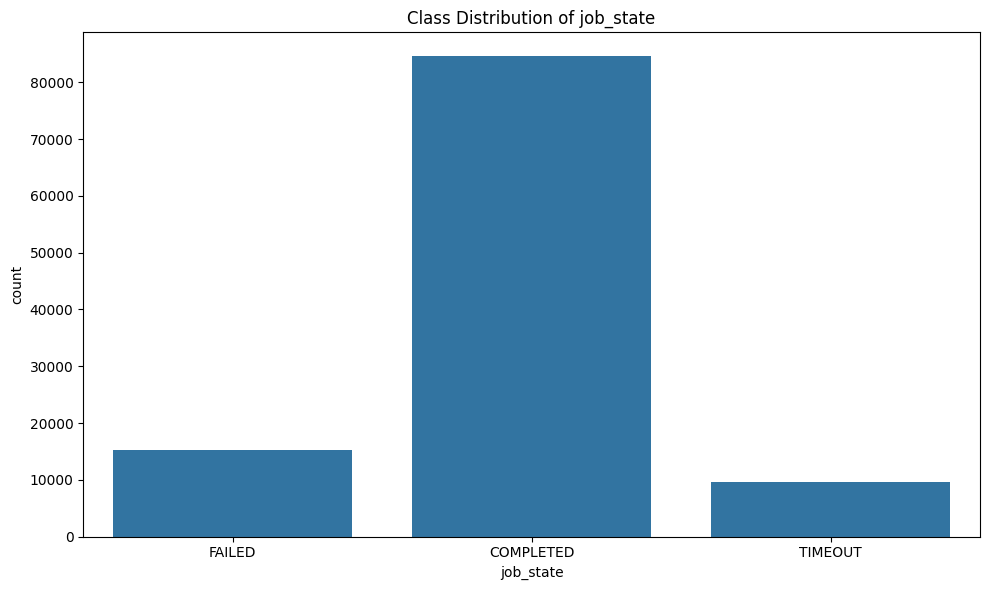

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='job_state', data=job_info_pre_execution)
plt.title('Class Distribution of job_state')
plt.tight_layout()
plt.show()

### Prediction using Random Forests

In [22]:
energy_consumption_per_jobs.describe()

,num_cpus,num_nodes,run_time,total_energy_consumed_by_job
count,165.000000,165.000000,165.000000,1.650000e+02
mean,2813.139394,23.496970,22055.121212,6.617411e+06
std,5365.427172,41.391148,31156.837006,1.199936e+07
min,48.000000,2.000000,61.000000,1.600000e+04
25%,256.000000,4.000000,875.000000,5.990000e+05
50%,1024.000000,12.000000,2793.000000,1.250000e+06
75%,3072.000000,24.000000,28815.000000,7.494800e+06
max,32768.000000,256.000000,86430.000000,8.701680e+07


In [23]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

# Initialize oversampler
ros = RandomOverSampler(random_state=42)

# Fit and apply the transform
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Initialize Random Forest classifier with balanced class weights
rf_model = RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

# Fit the model on the resampled training data
rf_model.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report and confusion matrix
print(classification_report(y_test, predictions, zero_division=1))
print(confusion_matrix(y_test, predictions))


Accuracy: 0.83
              precision    recall  f1-score   support

   COMPLETED       0.95      0.84      0.89     16945
      FAILED       0.62      0.80      0.70      3100
     TIMEOUT       0.46      0.71      0.55      1843

    accuracy                           0.83     21888
   macro avg       0.68      0.78      0.72     21888
weighted avg       0.86      0.83      0.84     21888

[[14295  1330  1320]
 [  376  2488   236]
 [  349   193  1301]]
